#  Data analysis on database created in setup_db.py

**Importing essential libraries and connecting to the database**

In [112]:
import psycopg2
from dotenv import load_dotenv
import os
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv()


engine = create_engine(
    f"postgresql+psycopg2://{os.getenv('User')}:{os.getenv('Password')}"
    f"@{os.getenv('Host')}/{os.getenv('DBname')}"
)


**loading data into a dataframe using a join query on my existing database**

In [113]:
query= """SELECT sales.product,sales.amount,sales.date,customer.name,customer.city
           FROM sales
            JOIN customer ON sales.customer_id=customer.id"""

df= pd.read_sql(query, engine)


**Looking at the created Dataframe**

In [114]:
df

,product,amount,date,name,city
0,Institution,810.0,2025-01-11,Audrey Blair MD,Davidtown
1,Stand,617.0,2025-01-15,Robert Mendoza,North Jessicamouth
2,Million,313.0,2025-04-25,Gary Harrison,Johnsonfort
3,Human,880.0,2025-11-15,Kimberly Gonzalez,Cruzton
4,Forget,800.0,2025-01-28,Kyle Long,Ericmouth
...,...,...,...,...,...
195,Tax,852.0,2025-07-13,Tiffany Young,New Gregoryport
196,Well,614.0,2025-07-24,Rose Mills,Davidburgh
197,Turn,676.0,2025-05-13,Paul Chavez,Pennyfort
198,Newspaper,788.0,2025-11-30,Rebecca Chavez,North Adrian


**Looking at nans or duplicated values(if any, likely not for this scenario):**

In [115]:
print(df.isna().sum())
print(df.duplicated().sum())

product    0
amount     0
date       0
name       0
city       0
dtype: int64
0


**Checking if columns with duplicate values exist**

In [116]:
d_columns = {y: df[y].duplicated().sum() for y in df.columns }

for col, count in d_columns.items():
    print(f"{col}: {count}")




product: 20
amount: 21
date: 37
name: 117
city: 119


**checking basic info and describing the data**

In [117]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   product  200 non-null    object 
 1   amount   200 non-null    float64
 2   date     200 non-null    object 
 3   name     200 non-null    object 
 4   city     200 non-null    object 
dtypes: float64(1), object(4)
memory usage: 7.9+ KB
None
          amount
count  200.00000
mean   645.87000
std    200.69756
min    305.00000
25%    482.00000
50%    642.00000
75%    810.25000
max    999.00000


# Analysis:

**Total sales by product(Fake data generated using fakers,names are random)**

In [118]:
sales= df.groupby('product')['amount'].sum()
sales

product
According     551.0
Actually      766.0
Add           904.0
Address       328.0
Again        1567.0
              ...  
Wonder        424.0
World         372.0
Worry        1734.0
Would         694.0
Yeah          524.0
Name: amount, Length: 180, dtype: float64

**Top 10 product with most sales**

In [119]:
most_sales= sales.sort_values(ascending=False).head(10)
most_sales_df= most_sales.reset_index()
most_sales_df


,product,amount
0,Series,1852.0
1,Tax,1804.0
2,Worry,1734.0
3,Again,1567.0
4,Mr,1520.0
5,Through,1486.0
6,Them,1466.0
7,Well,1456.0
8,Where,1394.0
9,Music,1286.0


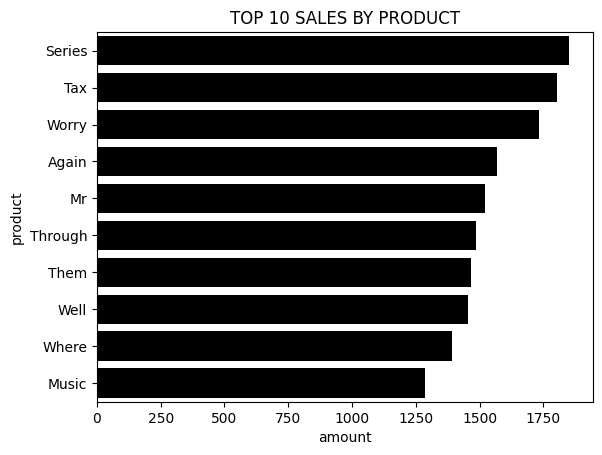

In [120]:
sns.barplot(data=most_sales_df, x='amount', y='product', color='black')
plt.title('TOP 10 SALES BY PRODUCT')
plt.show()

**Sales by city**

In [121]:
city= df.groupby('city')['amount'].sum()

**City with most purchases**

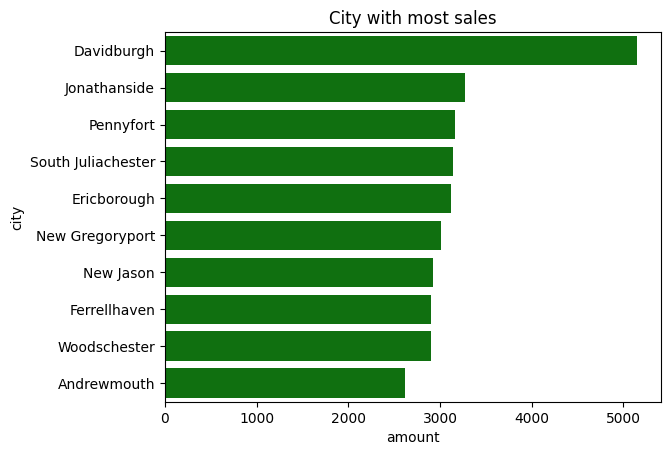

In [122]:
most_purchases= city.sort_values(ascending=False).head(10)
most_purchases_df= most_purchases.reset_index()

sns.barplot(data=most_purchases_df, x='amount', y='city', color='green')
plt.title("City with most sales")
plt.show()

**Monthly trends analysis**

In [123]:
# converting date which is in object to date_time data type 
df['date']=pd.to_datetime(df['date'])

# creating month column for better understanding and analysis
df['month']= df['date'].dt.to_period('M')
df['month']= df['month'].astype(str) # for plotting

monthly_sales= df.groupby('month')['amount'].sum().reset_index()
monthly_sales


,month,amount
0,2024-12,6964.0
1,2025-01,14823.0
2,2025-02,5508.0
3,2025-03,8314.0
4,2025-04,11635.0
5,2025-05,14816.0
6,2025-06,9747.0
7,2025-07,11362.0
8,2025-08,10583.0
9,2025-09,8333.0


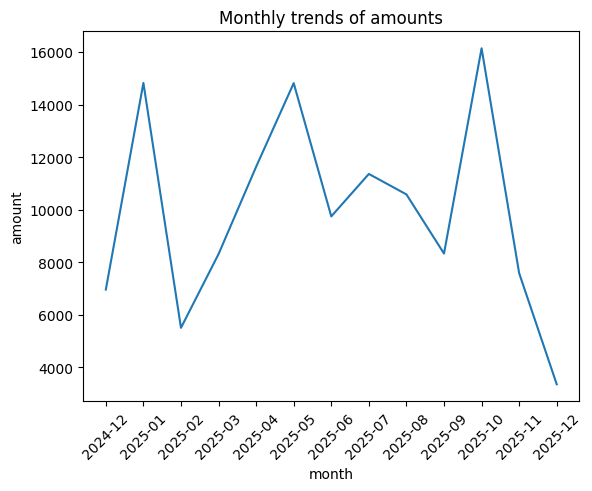

In [124]:
sns.lineplot(data=monthly_sales, x='month', y='amount')
plt.title("Monthly trends of amounts")
plt.xticks(rotation=45)
plt.show()

**product with declining sales**

In [ ]:
monthly_product_sales = df.groupby(['product', 'month'])['amount'].sum().reset_index()
pivot_df= monthly_product_sales.pivot(index='product', columns='month', values='amount').fillna(0)

def is_declining(row):
    return any(row.iloc[i]>row.iloc[i+1] for i in range(len(row)-1) if row.iloc[i+1]!=0)

pivot_df['declining']= pivot_df.apply(is_declining, axis=1)

declining_products = pivot_df[pivot_df['declining']]
declining_products



month,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,2025-10,2025-11,2025-12,declining
product,,,,,,,,,,,,,,
Worry,0.0,0.0,0.0,0.0,962.0,772.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


**concatenating some related Dataframes to push it to sql**

In [ ]:
concat_df= pd.concat([most_sales_df,most_purchases_df], axis=1)
concat_df.columns= ['product', 'total_sales', 'city', 'top_sales']
concat_df

,product,total_sales,city,top_sales
0,Series,1852.0,Davidburgh,5149.0
1,Tax,1804.0,Jonathanside,3272.0
2,Worry,1734.0,Pennyfort,3161.0
3,Again,1567.0,South Juliachester,3145.0
4,Mr,1520.0,Ericborough,3115.0
5,Through,1486.0,New Gregoryport,3008.0
6,Them,1466.0,New Jason,2920.0
7,Well,1456.0,Ferrellhaven,2907.0
8,Where,1394.0,Woodschester,2898.0
9,Music,1286.0,Andrewmouth,2621.0


**pushing this new acquired data to sql**

In [ ]:
concat_df.to_sql(
    name="summarytable",
    con=engine,
    if_exists='replace',
    index=False
)



10